This ipython notebook is intended for use with subcluster files (lists of cells) obtained through use of the Dropseq Viewer cell selection tool.

Given an analysis directory containing 
1. the original data file
2. the subcluster cell file
3. the classification file (if desired for coloring in TSNE/ZIFA/PCA)

This notebook will perform the following analysis:
1. generate a dataframe containing only the subset of cells identified in the Dropseq Viewer
2. Enrichment analysis - return the IDs for the top positively and negatively Differentially Expressed genes
3. Create a boxplot containing the distribution of DE among all genes
4. Create a subset dataframe file containing only the genes of interest 
    (manually input as a result of the output of enrichment analysis)
5. Run PCA, TSNE, or ZIFA on the subset of genes/cells -- these may need to be updated according to the desired configuration
    and order of running these.
6. Generate a heatmap for the subset of genes/cells


In [1]:
# activiate inline plotting
%pylab inline
# load modules
import pandas as pd
from sklearn import svm, cross_validation, feature_selection
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition.pca import PCA
import os
import json
import sys
from datetime import datetime
from sklearn import manifold
from scipy import stats
import seaborn as sns
from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import matplotlib.patches as mpatches

Populating the interactive namespace from numpy and matplotlib


In [2]:
#specify the input directory containing your original data, subcluster files, and classification file
analysis_directory = "C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\DropseqViewer\\analysis\\lupus_PvNID"
#specify the prefix directory at which new files will be saved (generally the same as the analysis_directory)
prefix = "C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\DropseqViewer\\analysis\\lupus_PvNID"

classification_json = {} #declare global variable 

In [5]:
#read in the data from the d3data.tsv file (genes in columns, cells in rows)
DF1 = pd.read_csv(os.path.join(prefix,"d3data.tsv"),sep="\t", index_col=0)

#specify the input cell subclass file to be used for analysis
cells_of_interest = open(os.path.join(prefix,"leftGroup.txt")).read().strip().split(',')
cells = []
for c in cells_of_interest:
    cellID = c.strip()
    cells.append(cellID)

#generate the subset cells file
subset_df = DF1[DF1.index.isin(cells)]
print(subset_df.shape)
other_cells = DF1[~DF1.index.isin(cells)]
print(other_cells.shape)
subset_df.to_csv(os.path.join(prefix,"genesubsetDF_loner_cells.txt"),sep="\t") #save data frame for subset of cells

(123, 6676)
(834, 6676)


In [6]:
#enrichment analysis - 
#determine which genes in the subset of cells are significantly enriched compared to all other cells
#THIS METHOD IS USING JUST THE MEAN VALUES

#not sure if mean is the best option (due to zeros) but we'll see.
subset_expression = subset_df.mean(axis=0)#subset_df.sum(axis=0)
other_cells_expression = other_cells.mean(axis=0)#other_cells.sum(axis=0)

subset_SD = subset_df.std(axis=0)
other_cells_SD = other_cells.std(axis=0)
result = []
for gene in subset_expression.index:
    result.append(log(float(subset_expression[gene]/other_cells_expression[gene])))
    
enrichment_df = pd.Series(np.asarray(result), index=subset_expression.index)
#output the resulting 25 most over-expressed and 25 most under-expressed genes and their corresponding DE value
print(enrichment_df.order(ascending=False).head(25))
print(enrichment_df.order(ascending=True).head(25))


XIST             2.563216
DMPK             2.324109
NCALD            2.119293
MIR1244-3        1.900422
MIR1244-1        1.895891
FLJ44635         1.876388
DENND2D          1.866625
MIR1244-2        1.856547
CASK             1.787400
ICAM2            1.640055
IL7R             1.592365
HOPX             1.579005
ING4             1.429727
STAP2            1.426322
LOXL1-AS1        1.401625
TMEM68           1.375145
ZNF461           1.374386
C21ORF91         1.359633
ZNF670-ZNF695    1.346815
TP53             1.330472
CTBP2            1.330412
PRR29            1.317781
CCT7             1.295182
CSF2RA           1.291538
LOC101928795     1.289276
dtype: float64
CPVL            -inf
TYMP            -inf
IGLL3P          -inf
SERPINA1        -inf
USP9Y           -inf
RPS4Y1          -inf
DDX3Y           -inf
DUSP6           -inf
ATF3            -inf
EIF1AY          -inf
HBD             -inf
CXCL8           -inf
VCAN       -5.272280
PF4V1      -4.626991
CFL2       -4.506794
CLU        -4.488460

C:\Users\KATRINA\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\KATRINA\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: order is deprecated, use sort_values(...)


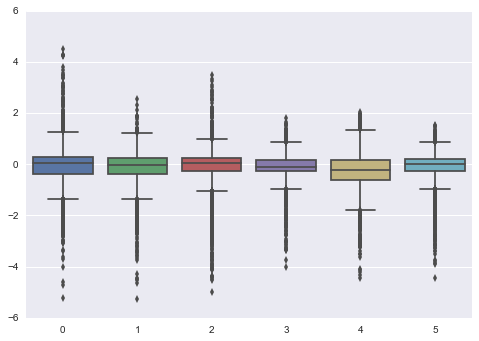

In [39]:
#plot distribution of fold changes
#note: the following dataframes were obtained by running the above enrichment script multiple times in one session
#      with different DF names

#upper_group_enrichment = enrichment_df
#left_group_enrichment = enrichment_df
#right_group_enrichment = enrichment_df
#middle_main_enrichment = enrichment_df
#middle_top_enrichment = enrichment_df
#middle_LL_enrichment = enrichment_df

data2 = [upper_group_enrichment,left_group_enrichment,right_group_enrichment,middle_main_enrichment,middle_top_enrichment, 
         middle_LL_enrichment]

#plot boxplot without outliers marked on plot
#sns.boxplot(data=data2,
#                showfliers=False)
#plt.savefig(os.path.join(prefix,"boxplot_ULRMmMtMll_noFliers.png"))


#plot boxplot with outliers marked on plot
sns.boxplot(data=data2,
                showfliers=True)


In [37]:
#just print the top 25 over-expressed and under-expressed genes (as calculated in DE step)
#this allows you to view the data without re-creating files and recomputing.

print(left_group_enrichment.order(ascending=False).head(25))
print(left_group_enrichment.order(ascending=True).head(25))

XIST             2.563216
DMPK             2.324109
NCALD            2.119293
MIR1244-3        1.900422
MIR1244-1        1.895891
FLJ44635         1.876388
DENND2D          1.866625
MIR1244-2        1.856547
CASK             1.787400
ICAM2            1.640055
IL7R             1.592365
HOPX             1.579005
ING4             1.429727
STAP2            1.426322
LOXL1-AS1        1.401625
TMEM68           1.375145
ZNF461           1.374386
C21ORF91         1.359633
ZNF670-ZNF695    1.346815
TP53             1.330472
CTBP2            1.330412
PRR29            1.317781
CCT7             1.295182
CSF2RA           1.291538
LOC101928795     1.289276
dtype: float64
CPVL            -inf
TYMP            -inf
IGLL3P          -inf
SERPINA1        -inf
USP9Y           -inf
RPS4Y1          -inf
DDX3Y           -inf
DUSP6           -inf
ATF3            -inf
EIF1AY          -inf
HBD             -inf
CXCL8           -inf
VCAN       -5.272280
PF4V1      -4.626991
CFL2       -4.506794
CLU        -4.488460

C:\Users\KATRINA\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':
C:\Users\KATRINA\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


In [102]:
#select the N most expressed genes:
most_expressed_genes = subset_df.sum(axis=0).order(ascending=False).head(50)
print(most_expressed_genes)

variance       1.517907e+08
MALAT1         1.682827e+06
RPL17          2.338902e+05
RPL13          2.263531e+05
IKZF3          1.874659e+05
MTRNR2L8       1.797771e+05
RPL13A         1.787919e+05
MTRNR2L2       1.641196e+05
TPT1           1.605000e+05
EEF1A1         1.448951e+05
RPS27A         1.349381e+05
CFLAR          1.345474e+05
KCNQ1OT1       1.325774e+05
RPS3           1.311267e+05
B2M            1.119885e+05
RPL41          1.096248e+05
MDM4           1.094766e+05
ATXN3          1.093345e+05
TPM3           1.083530e+05
TMSB4X         1.057560e+05
RPS24          1.033577e+05
RPS6           1.012063e+05
RPS14          1.003316e+05
RPL15          9.981229e+04
RPL10          9.851322e+04
ORC4           9.634007e+04
ORAI2          9.552118e+04
TXNIP          9.085776e+04
RPS17          8.844156e+04
RPL34          8.338123e+04
RPL11          8.214179e+04
RPS3A          7.849877e+04
MTRNR2L1       7.736100e+04
LPP            7.731781e+04
RPS29          7.565275e+04
PTPRC          7.562

C:\Users\KATRINA\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


In [197]:
#read in a combined dataframe
DFcomb = pd.read_csv(os.path.join(prefix,"lupus_combinedL4.csv"),sep=",", index_col=0)

#manually set the classification vector
classification = [700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300]

#DF_final = DFcomb[:-1] #hopefully this will get all rows except for the last one
#print(DFcomb.columns.values)
#DF_final = DFcomb.drop('cell_class', axis=1, inplace=True)
DF_final = DFcomb

#optionally, run the select k best function to select the most "separating" genes
'''
print("selecting k best")

DFt = DF_final#DF_final.transpose()

sample_classification = classification

# select k best - TODO: Look up how this algorithm works behind the scenes
X_new = feature_selection.SelectKBest(feature_selection.chi2, k=75).fit_transform(DFcomb, sample_classification)
print('X_new created')
n = feature_selection.SelectKBest(feature_selection.chi2,k=75).fit(DFcomb, sample_classification)

#print(X_new)
print(n)
t = n.get_support()
indices_of_interest = [i for i, x in enumerate(t) if x]
print(indices_of_interest)
genes_of_interest = []

print("obtaining genes of interest")
for i in indices_of_interest:
    g = DFcomb.columns.values[i]
    if 'RPS' not in g:
        if 'RPL' not in g:
            if 'RB' not in g:
                genes_of_interest.append(DFcomb.columns.values[i])

'''

#otherwise, input a set of "genes of interest" obtained from the DE analysis
genes_of_interest=['BCOR','ARFGAP1','KIF21A','CCDC144CP','SOCS3','CD8A','PIGT','GPRIN3','FRS2','HN1','TMEM147','SLIRP','IL32','IFITM3','COL19A1','KIAA0226L','ADAM28','BLNK','MS4A1','XIST','DMPK','NCALD','MIR1244-3','MIR1244-1','VCAN','SERPINA1','S100A9','CXCL8','S100A8']
print(genes_of_interest)

DFcT = DFcomb.transpose()
subset_df = DFcT[DFcT.index.isin(genes_of_interest)]

subset_df.to_csv(os.path.join(prefix,"genesubsetDF.txt"),sep="\t")
#print(len(subset_df.columns.values))
#print(len(subset_df.index))
#print("writing subset dataframe to file")
#subset_df.to_csv("C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\Data\\Lupus_data\\" + "_df_result.tsv",sep="\t")



['DDX11L1' 'WASH7P' 'MIR6859-1' ..., 'GOLGA2P2Y' 'GOLGA2P3Y'
 'classification']
['BCOR', 'ARFGAP1', 'KIF21A', 'CCDC144CP', 'SOCS3', 'CD8A', 'PIGT', 'GPRIN3', 'FRS2', 'HN1', 'TMEM147', 'SLIRP', 'IL32', 'IFITM3', 'COL19A1', 'KIAA0226L', 'ADAM28', 'BLNK', 'MS4A1', 'XIST', 'DMPK', 'NCALD', 'MIR1244-3', 'MIR1244-1', 'VCAN', 'SERPINA1', 'S100A9', 'CXCL8', 'S100A8']


In [198]:
#Run PCA - currently set to run on the subset_Df but can also run on the full dataframe in a reasonable amount of time
pca = PCA(n_components=15)
print(pca)

pcaF = pca.fit(subset_df)#DF_final)
print(pcaF)

PCA(copy=True, n_components=15, whiten=False)
PCA(copy=True, n_components=15, whiten=False)


3831
15
begin tSNE
completed tSNE


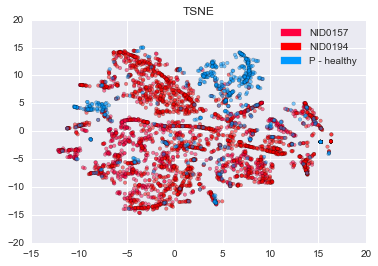

In [199]:
# run TSNE 

#X = subset_df.transpose() #DF_final.transpose()
X = (pca.components_).transpose()
#X = (Z_trans)
n_samples, n_features = X.shape[0],X.shape[1]
print(n_samples)
print(n_features)
print("begin tSNE")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
# plot the result
vis_x = X_tsne[:,0]
vis_y = X_tsne[:,1] #1]
print("completed tSNE")

# plot TSNE

#color_options = ["#ff9900","#cc0066","#9900cc"]
#color_options = ["#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff"]
color_options = ["#ffff52","#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff","#ff0040","#ff0040","#ff0000","#ff0000",
                 "#0099ff","#0099ff","#0099ff"]
#color_options = ["red", "blue","orange"]
color=[]
for i in classification:
    color.append(color_options[int((i/100))])#-1)]) 

area = np.pi *(2)**2 
plt.scatter(vis_x,vis_y, s=area, c=color, alpha = 0.5)

#create a legend - must update this manually to match the colors indicated by the classification vector
s1 = mpatches.Patch(color="#ff0040", label='NID0157')
s2 = mpatches.Patch(color="#ff0000", label='NID0194')
s3 = mpatches.Patch(color="#0099ff", label='P - healthy')
plt.legend(handles=[s1,s2,s3])

plt.title("TSNE")

ValueError: Linkage 'Z' contains negative indices.

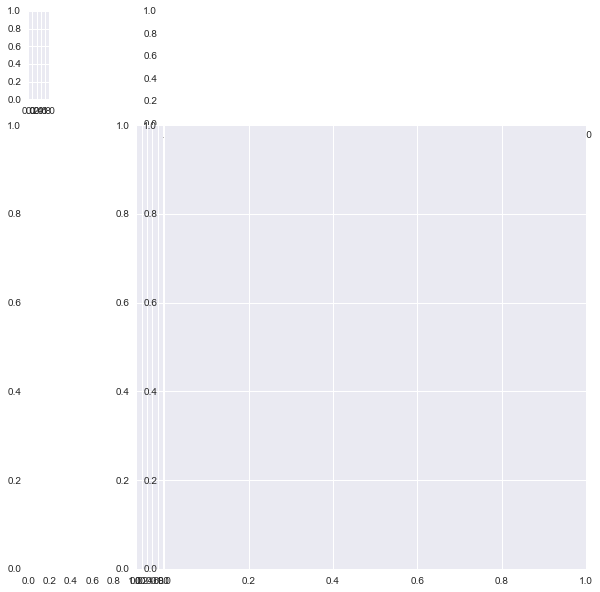

In [212]:
#Plot a clustermap for the dataframe

#color_options = ["#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff"]
color_options = ["#ffff52","#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff","#ff0040","#ff0040","#ff0000","#ff0000",
                 "#0099ff","#0099ff","#0099ff"]
color=[]
for i in classification:
    color.append(color_options[int((i/100))])#-1)])

dff = subset_df.transpose()
#dff = dedfT[dedfT.index.isin(genes)]
x = sns.clustermap(dff,vmax=2000,cmap="YlGnBu", row_colors=color, metric='jaccard') #method='single'...
#c = x.dendrogram_col.reordered_ind
#cell_names = dff.columns.values()


In [202]:
# run ZIFA
# https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0805-z
# https://github.com/epierson9/ZIFA

f = lambda x: np.log(1+x)
logDF = subset_df.applymap(f) #DF_final.applymap(f) #
#logDF = DF_final.applymap(f)

#Z, model_params = block_ZIFA.fitModel(logDF.as_matrix(), 2)
#Z, model_params = ZIFA.fitModel(logDF.as_matrix(), 2)

transposed_ZIFA = logDF.transpose()
Z_trans, MP_trans = ZIFA.fitModel(transposed_ZIFA.as_matrix(),2)

print('ZIFA finished')

Running zero-inflated factor analysis with N = 3831, D = 29, K = 2
Param change below threshold 1.000e-02 after 25 iterations
ZIFA finished


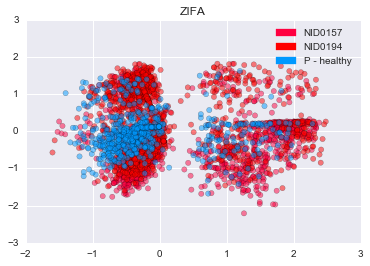

In [203]:
#plot ZIFA

#color_options = ["#ff9900","#cc0066","#9900cc"]
#color_options = ["#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff"]
color_options = ["#ffff52","#005ce6","#ff9900","#cc0066","#33ccff","#00e600","#a64dff","#ff0040","#ff0040","#ff0000","#ff0000",
                 "#0099ff","#0099ff","#0099ff"]
color=[]
for i in classification:
    #print(str((i/100)-1))
    color.append(color_options[int((i/100))])#-1)])

# plot ZIFA
area = np.pi *(3)**2 
X=[]
Y=[]
for i in Z_trans:
    X.append(i[0])
    Y.append(i[1])
    
plt.scatter(X,Y, s=area, alpha=0.5, c=color)
#create a legend - must update this manually to match the colors indicated by the classification vector
s1 = mpatches.Patch(color="#ff0040", label='NID0157')
s2 = mpatches.Patch(color="#ff0000", label='NID0194')
s3 = mpatches.Patch(color="#0099ff", label='P - healthy')
plt.legend(handles=[s1,s2,s3])

plt.title("ZIFA")

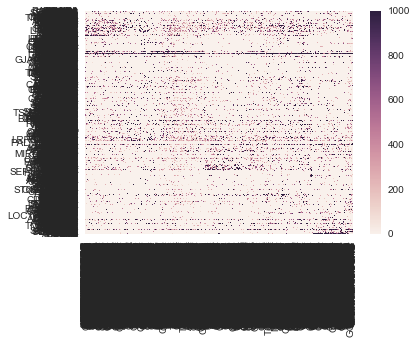

In [122]:
#create a HEATMAP - intended for use with BackSPIN results

base_dir = "C:\\cygwin64\\home\\KATRINA\\UCB\\Research\\DerisiLab\\Data\\Lupus_data\\analysis_testipython\\PvNID\\backspin\\"
bsdf = pd.read_csv(base_dir + "smallerDF_BS_output_HMfile.txt", sep='\t',index_col=0)
sns.heatmap(bsdf,vmax=1000)


In [210]:
#Determine the intersection between two sets of genes

a = set(['BCOR','ARFGAP1','KIF21A','CCDC144CP','SLAMF1','NFATC2','FAM13A','IFT74','PLCG1','AASDH','IL24','ZBTB20','TTN','TMEM134','DCUN1D4','AP1G2','RANBP6','YY1AP1','MAPK9','F5','ZNF138','TEX264','PFDN6','VPS11','GTF3C3','TBC1D4','UTP14A','MAF','SMAD3','THEMIS','C11ORF73','CCDC141','NABP1','PRG4','ODF2','LOC101928103','MGAT1','GMPR2','KIAA0586','SPDYE8P','TNIP3','PUS7L','SP1','TNRC6C','ANKRD32','ANKFY1','PHYKPL','DCTN3','TFRC','DCAF5'])
b=set(['ABHD2','ACSL3','ACTR8','ALAS1','ALOX5AP','AOAH','APOBEC3C','APOBEC3G','AQR','ARAP2','ARHGAP33','ARHGEF12','ASPM','ATG12','ATP10D','ATP6V1A','BARD1','BAZ2B','BCL2L2','BIRC2','BLM','C17orf75','C1orf174','C2CD3','C5orf15','C8orf60','CBLB','CDC42EP3','CDK12','CHST12','CLIC3','CLTC','COPB1','COPB2','CPD','CREB3L2','CTBP2','CTR9','CTSO','CXorf40B','DCAF7','DCUN1D1','DDX23','DUSP22','ENPP4','FAIM','FAM13B','FEZ2','FMR1','GALNT3','GALNT7','GGNBP2','GMEB1','GSN','GTF2E1','HARS2','HIPK2','HLTF','HSPA1A','IDH1','IGF2R','IL18RAP','INPP1','INTS6','ITCH','KEAP1','KIAA0317','KIFAP3','KIR2DL4','KLHDC10','KLRD1','KPNA3','KRIT1','LAMP1','LARP7','LASP1','LAT2','LPIN1','LRCH3','MCF2L2','MCTP2','MED20','MED8','MLEC','MRFAP1L1','MRPS22','MTG1','MUDENG','MUT','NARF','NCAM1','NCR1','NDUFAF1','NEK7','NPC1','NRF1','NUP107','NUP133','NUP43','PCTP','PDCL','PHF21A','PHTF1','PIGB','PIGV','PLAGL1','PLCG2','PLEKHO2','POLD3','POLE2','PON2','PPP1R3D','PPP1R8','PRKAR1A','PSME4','PSPC1','PTPN22','PTPRC','PTPRE','RAB5A','RAC1','RAD23B','RAD50','RFX7','RHBDF2','RNF115','RNF34','RNF4','RRAS2','RSF1','S1PR5','SART3','SEC24C','SECISBP2L','SEL1L','SEPHS2','SLC27A3','SLFN12','SMAD5','SNAP29','SNX5','SPATA5L1','STAMBP','STAU2','STK39','STOM','STX4','STX6','STX7','SUCLA2','SUV420H1','TAPBPL','TARDBP','TBL1X','TCF12','TFIP11','THOC2','TIMM8B','TINF2','TIPRL','TM6SF1','TMEM87A','TNFRSF1A','TNPO1','TOR1B','TOX','TRAF5','TRD@','TRIM58','TRIP12','TRIP4','TXNDC9','UBB','UBE2W','UBXN4','UCK2','UNC50','USP8','UTP11L','UTP14C','VPS26A','VPS41','VPS4B','WDR67','WIPF1','XCL1','YARS','YES1','YPEL1','ZCCHC6','ZDHHC17','ZFAND6','ZFYVE16','ZMPSTE24','ZNF12','ZNF187','ZNF226','ZNF264','ZNF544','ZWILCH'])

#print(a)
#print(b)
print(a.intersection(b))

{'TTN', 'KIF21A', 'MAF', 'PRG4', 'NABP1', 'F5', 'ZNF138', 'GMPR2', 'VPS11', 'ANKRD32', 'SPDYE8P', 'DCUN1D4', 'NFATC2', 'AP1G2', 'RANBP6', 'GTF3C3', 'TFRC', 'ANKFY1', 'TBC1D4', 'PUS7L', 'ZBTB20', 'ARFGAP1', 'IL24', 'CCDC144CP', 'C11ORF73', 'YY1AP1', 'LOC101928103', 'DCTN3', 'FAM13A', 'IFT74', 'THEMIS', 'SLAMF1', 'PHYKPL', 'ODF2', 'DCAF5', 'SP1', 'TNIP3', 'MAPK9', 'TNRC6C', 'TEX264', 'BCOR', 'MGAT1', 'SMAD3', 'TMEM134', 'UTP14A', 'PLCG1', 'AASDH', 'KIAA0586', 'PFDN6', 'CCDC141'}
{'CLTC', 'UBXN4', 'ACTR8', 'ZWILCH', 'RNF4', 'KIAA0317', 'ALOX5AP', 'ARHGEF12', 'FMR1', 'SLFN12', 'CLIC3', 'C8orf60', 'NCAM1', 'PDCL', 'PSME4', 'TBL1X', 'LASP1', 'SMAD5', 'WIPF1', 'KEAP1', 'SEC24C', 'NDUFAF1', 'COPB2', 'SUV420H1', 'DDX23', 'NEK7', 'PSPC1', 'YARS', 'POLE2', 'CREB3L2', 'S1PR5', 'SLC27A3', 'RRAS2', 'ATP6V1A', 'TRIP4', 'RSF1', 'ITCH', 'VPS26A', 'ZNF264', 'PLAGL1', 'ZCCHC6', 'FAM13B', 'PTPN22', 'ENPP4', 'ZFYVE16', 'TIMM8B', 'COPB1', 'TNFRSF1A', 'RHBDF2', 'PON2', 'ZNF544', 'MCTP2', 'DCUN1D1', 'TIPRL', 